# 01 — Exploratory Data Analysis

**Dataset:** `filtered_data.csv`  
**Cohorts:** Two mutually exclusive groups, both sepsis patients:
- **Non-ARDS** (`ards == False`) — sepsis without ARDS
- **ARDS** (`ards == True`) — sepsis with moderate or severe ARDS (mild ARDS excluded)

**Sections:**
1. Setup
2. Load data & cohort overview
3. Confounding factors — sex, age, ICU ward
4. Protein data — global overview
5. Protein data — ARDS vs Non-ARDS differential analysis

## 1. Setup

In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make src/ importable when running from notebooks/
sys.path.append("..")

from src.styles.colors import get_colors
from src.core.data_utils import create_subsets, get_protein_features, get_top_diff_features
from src.core.plot_utils import (
    corr_matrix,
    hierarchical_feature_order,
    plot_correlation_heatmap,
)

In [2]:
# ── Colour setup ──────────────────────────────────────────────────────────────
COLOR       = get_colors("palette")          # dict: name → hex
ARDS_COLORS = get_colors("ards")             # dict: ARDS label → hex
COLORS      = get_colors("categorical")      # list for categorical data
COLORS_SEQ_TEAL   = get_colors("sequential_teal")
COLORS_SEQ_ORANGE = get_colors("sequential_orange")

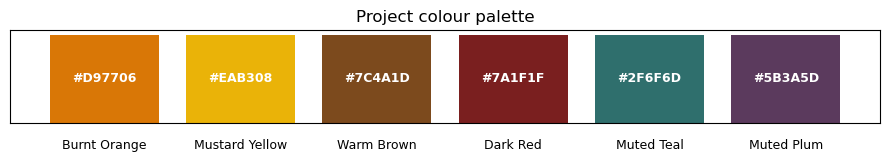

In [3]:
# ── Palette preview ───────────────────────────────────────────────────────────
palette_preview = {
    "Burnt Orange":   "#D97706",
    "Mustard Yellow": "#EAB308",
    "Warm Brown":     "#7C4A1D",
    "Dark Red":       "#7A1F1F",
    "Muted Teal":     "#2F6F6D",
    "Muted Plum":     "#5B3A5D",
}
fig, ax = plt.subplots(figsize=(9, 1.8))
for i, (name, hex_code) in enumerate(palette_preview.items()):
    ax.bar(i, 1, color=hex_code)
    ax.text(i, -0.18, name,      ha="center", va="top",    fontsize=9)
    ax.text(i,  0.50, hex_code,  ha="center", va="center", fontsize=9,
            color="white", fontweight="bold")
ax.set(xticks=[], yticks=[], title="Project colour palette")
plt.tight_layout()
plt.show()

## 2. Load data & cohort overview

In [4]:
df = pd.read_csv("../data/processed/filtered_data.csv")
df.head()

C:\Users\Love\AppData\Local\Temp\ipykernel_3392\2320089628.py:1: DtypeWarning: Columns (10818,10820) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/filtered_data.csv")


,PlateId,PlateRunDate,ScannerID,PlatePosition,SlideId,Subarray,SampleId,SampleType,PercentDilution,SampleMatrix,...,age,female,icu_start.y,los_minutes,vent_time,survival_days,mort30d,mort90d,saps3_total,saps3_emr_swe
0,PLT36510,2024-12-17,SG17164580,B1,258740120244,2,2008687169,Sample,20,EDTA Plasma,...,79.0,False,2016-06-13T16:26:00Z,3094.0,90.0,1596.0,False,False,86.0,69.5
1,PLT36510,2024-12-17,SG17164580,E1,258740120244,5,2006647841,Sample,20,EDTA Plasma,...,45.0,False,2016-04-12T21:00:00Z,4080.0,3540.0,3.0,True,True,65.0,28.0
2,PLT36510,2024-12-17,SG17164580,A2,258740120245,1,2008724803,Sample,20,EDTA Plasma,...,70.0,False,2016-04-11T23:00:00Z,3645.0,2060.0,1659.0,False,False,59.0,17.6
3,PLT36510,2024-12-17,SG17164580,F2,258740120245,6,2008937634,Sample,20,EDTA Plasma,...,81.0,True,2016-04-23T13:30:00Z,2910.0,1500.0,1136.0,False,False,94.0,80.2
4,PLT36510,2024-12-17,SG17164580,H2,258740120245,8,2008959801,Sample,20,EDTA Plasma,...,48.0,False,2016-01-26T11:00:00Z,10290.0,7125.0,1735.0,False,False,53.0,10.0


In [5]:
# ── Split into ARDS / Non-ARDS cohorts ───────────────────────────────────────
subsets = create_subsets(df)
ards_data     = subsets.ards
non_ards_data = subsets.non_ards

print(f"Total patients:          {len(df):>6}")
print(f"  ARDS (mod/severe):     {len(ards_data):>6}")
print(f"  Non-ARDS:              {len(non_ards_data):>6}")
print()
print(f"Female — ARDS:           {ards_data['female'].sum():>6}")
print(f"Female — Non-ARDS:       {non_ards_data['female'].sum():>6}")
print(f"Male   — ARDS:           {(ards_data['female'] == 0).sum():>6}")
print(f"Male   — Non-ARDS:       {(non_ards_data['female'] == 0).sum():>6}")

Total patients:             408
  ARDS (mod/severe):         65
  Non-ARDS:                 343

Female — ARDS:               24
Female — Non-ARDS:          133
Male   — ARDS:               41
Male   — Non-ARDS:          210


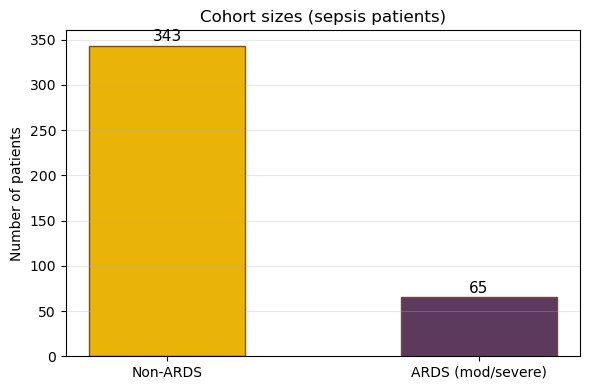

In [6]:
# ── Cohort bar chart ─────────────────────────────────────────────────────────
labels  = ["Non-ARDS", "ARDS (mod/severe)"]
counts  = [len(non_ards_data), len(ards_data)]
bar_colors = [ARDS_COLORS["Not ARDS"], ARDS_COLORS["ARDS"]]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, counts, color=bar_colors, edgecolor=COLOR["neutral"], width=0.5)
for bar, n in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
            str(n), ha="center", va="bottom", fontsize=11)
ax.set(ylabel="Number of patients", title="Cohort sizes (sepsis patients)")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Confounding factors

### 3.1 Sex distribution

Total — Men: 251,  Women: 157


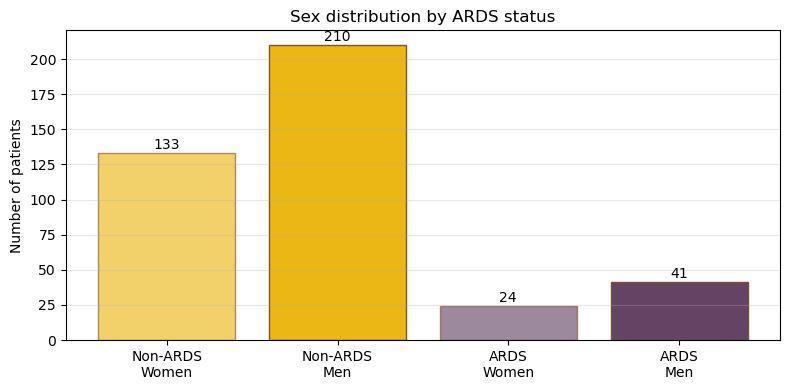

In [7]:
nbr_men   = df["female"].value_counts().get(False, 0)
nbr_women = df["female"].value_counts().get(True, 0)
print(f"Total — Men: {nbr_men},  Women: {nbr_women}")

# Grouped bar: sex × ARDS status
groups = {
    "Non-ARDS\nWomen": len(non_ards_data[non_ards_data["female"] == True]),
    "Non-ARDS\nMen":   len(non_ards_data[non_ards_data["female"] == False]),
    "ARDS\nWomen":     len(ards_data[ards_data["female"] == True]),
    "ARDS\nMen":       len(ards_data[ards_data["female"] == False]),
}
bar_cols = [
    ARDS_COLORS["Not ARDS"], ARDS_COLORS["Not ARDS"],
    ARDS_COLORS["ARDS"],     ARDS_COLORS["ARDS"],
]
alphas = [0.6, 0.95, 0.6, 0.95]  # women lighter, men darker

fig, ax = plt.subplots(figsize=(8, 4))
for i, (label, count) in enumerate(groups.items()):
    bar = ax.bar(i, count, color=bar_cols[i], alpha=alphas[i],
                 edgecolor=COLOR["neutral"])
    ax.text(i, count + 1, str(count), ha="center", va="bottom", fontsize=10)
ax.set_xticks(range(len(groups)))
ax.set_xticklabels(groups.keys())
ax.set(ylabel="Number of patients", title="Sex distribution by ARDS status")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 Age distribution

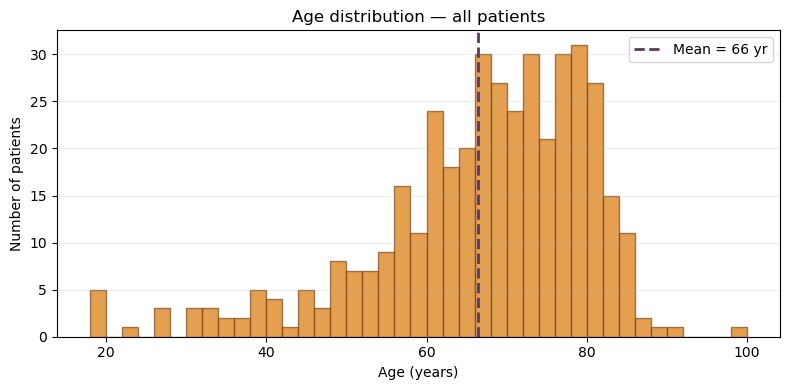

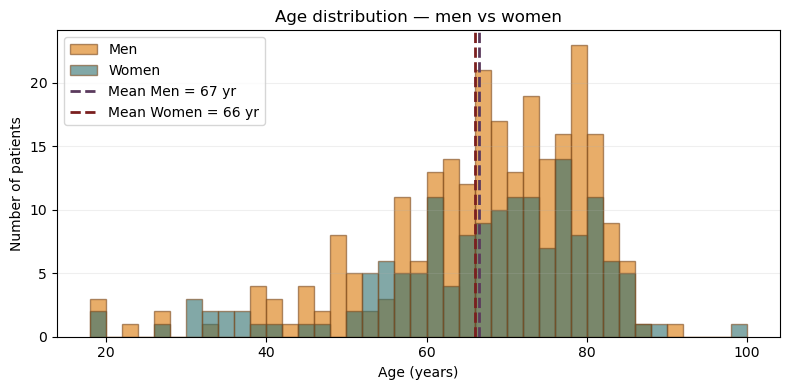

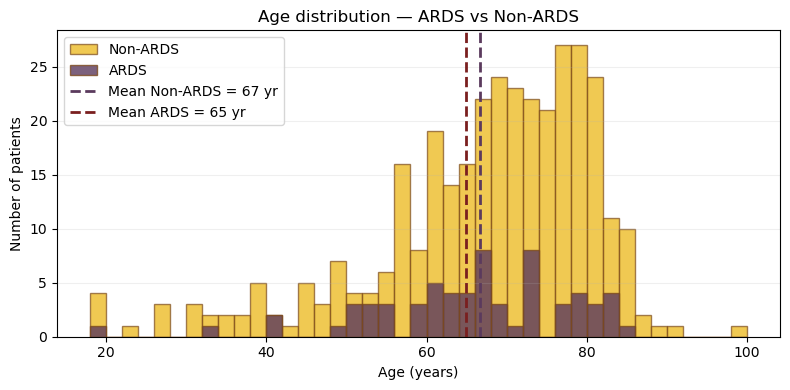

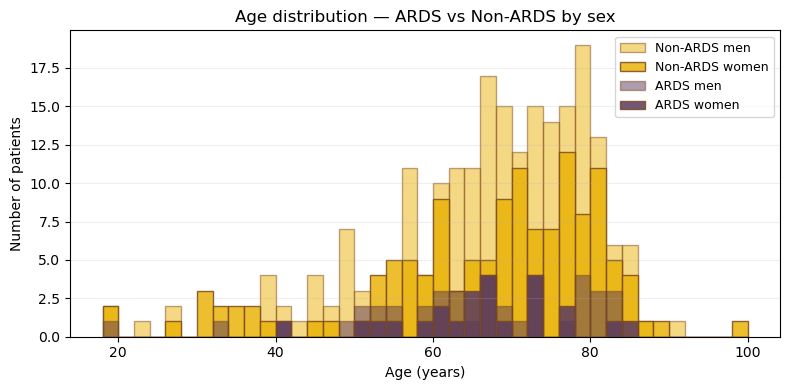

In [8]:
ages = df["age"].dropna()
bins = range(int(ages.min()), int(ages.max()) + 2, 2)

# ── All patients ─────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(ages, bins=bins, color=COLOR["primary"],
        edgecolor=COLOR["neutral"], alpha=0.7)
ax.axvline(ages.mean(), linestyle="--", color=COLOR["accent"],
           linewidth=2, label=f"Mean = {ages.mean():.0f} yr")
ax.set(title="Age distribution — all patients",
       xlabel="Age (years)", ylabel="Number of patients")
ax.legend()
ax.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()

# ── Men vs Women ──────────────────────────────────────────────────────────────
ages_men   = df[df["female"] == False]["age"].dropna()
ages_women = df[df["female"] == True]["age"].dropna()

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(ages_men,   bins=bins, color=COLOR["primary"],   edgecolor=COLOR["neutral"],
        alpha=0.6, label="Men")
ax.hist(ages_women, bins=bins, color=COLOR["secondary"], edgecolor=COLOR["neutral"],
        alpha=0.6, label="Women")
ax.axvline(ages_men.mean(),   linestyle="--", color=COLOR["accent"],
           linewidth=2, label=f"Mean Men = {ages_men.mean():.0f} yr")
ax.axvline(ages_women.mean(), linestyle="--", color=COLOR["danger"],
           linewidth=2, label=f"Mean Women = {ages_women.mean():.0f} yr")
ax.set(title="Age distribution — men vs women",
       xlabel="Age (years)", ylabel="Number of patients")
ax.legend()
ax.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()

# ── ARDS vs Non-ARDS ─────────────────────────────────────────────────────────
ages_non_ards = non_ards_data["age"].dropna()
ages_ards     = ards_data["age"].dropna()

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(ages_non_ards, bins=bins, color=ARDS_COLORS["Not ARDS"],
        edgecolor=COLOR["neutral"], alpha=0.7, label="Non-ARDS")
ax.hist(ages_ards, bins=bins, color=ARDS_COLORS["ARDS"],
        edgecolor=COLOR["neutral"], alpha=0.8, label="ARDS")
ax.axvline(ages_non_ards.mean(), linestyle="--", color=COLOR["accent"],
           linewidth=2, label=f"Mean Non-ARDS = {ages_non_ards.mean():.0f} yr")
ax.axvline(ages_ards.mean(), linestyle="--", color=COLOR["danger"],
           linewidth=2, label=f"Mean ARDS = {ages_ards.mean():.0f} yr")
ax.set(title="Age distribution — ARDS vs Non-ARDS",
       xlabel="Age (years)", ylabel="Number of patients")
ax.legend()
ax.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()

# ── ARDS vs Non-ARDS split by sex ────────────────────────────────────────────
subgroups = {
    "Non-ARDS men":   non_ards_data[non_ards_data["female"] == False]["age"].dropna(),
    "Non-ARDS women": non_ards_data[non_ards_data["female"] == True]["age"].dropna(),
    "ARDS men":       ards_data[ards_data["female"] == False]["age"].dropna(),
    "ARDS women":     ards_data[ards_data["female"] == True]["age"].dropna(),
}
sg_colors = [
    ARDS_COLORS["Not ARDS"], ARDS_COLORS["Not ARDS"],
    ARDS_COLORS["ARDS"],     ARDS_COLORS["ARDS"],
]
sg_alphas = [0.5, 0.85, 0.5, 0.85]

fig, ax = plt.subplots(figsize=(8, 4))
for (label, sg_ages), col, alpha in zip(subgroups.items(), sg_colors, sg_alphas):
    ax.hist(sg_ages, bins=bins, color=col,
            edgecolor=COLOR["neutral"], alpha=alpha, label=label)
ax.set(title="Age distribution — ARDS vs Non-ARDS by sex",
       xlabel="Age (years)", ylabel="Number of patients")
ax.legend(fontsize=9)
ax.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()

### 3.3 ICU ward (IVAavd)

In [9]:
counts_ards = (
    df.groupby(["IVAavd", "ards"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={False: "Non-ARDS", True: "ARDS"})
)
counts_ards["Total"]    = counts_ards.sum(axis=1)
counts_ards["ARDS_pct"] = (counts_ards["ARDS"] / counts_ards["Total"] * 100).round(1)
print(counts_ards.sort_values("Total", ascending=False).to_string())

ards         Non-ARDS  ARDS  Total  ARDS_pct
IVAavd                                      
Malmo             129    29    158      18.4
Helsingborg       124    10    134       7.5
Lund               90    26    116      22.4


## 4. Protein data — global overview

In [10]:
# ── Identify protein columns ──────────────────────────────────────────────────
features     = get_protein_features(df)
protein_data = df[features]

protein_ards     = ards_data[features]
protein_non_ards = non_ards_data[features]

print(f"Total proteins:          {len(features)}")
print(f"Protein matrix shape:    {protein_data.shape}")
print(f"  ARDS patients:         {protein_ards.shape[0]}")
print(f"  Non-ARDS patients:     {protein_non_ards.shape[0]}")
print()

vals = protein_data.values.flatten()
print(pd.Series(vals).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]))

Total proteins:          10776
Protein matrix shape:    (408, 10776)
  ARDS patients:         65
  Non-ARDS patients:     343

count    4.396608e+06
mean     3.041926e+00
std      5.935020e-01
min      2.552725e-01
25%      2.626648e+00
50%      2.934902e+00
75%      3.347310e+00
90%      3.881369e+00
99%      4.782814e+00
max      5.789651e+00
dtype: float64


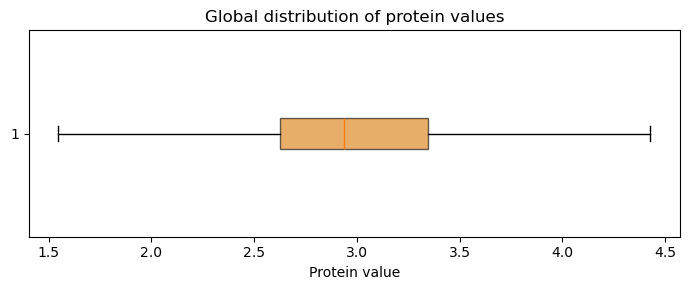

In [11]:
# ── Global boxplot ─────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 3))
ax.boxplot(vals, vert=False, showfliers=False,
           patch_artist=True,
           boxprops=dict(facecolor=COLOR["primary"], alpha=0.6))
ax.set(xlabel="Protein value", title="Global distribution of protein values")
plt.tight_layout()
plt.show()

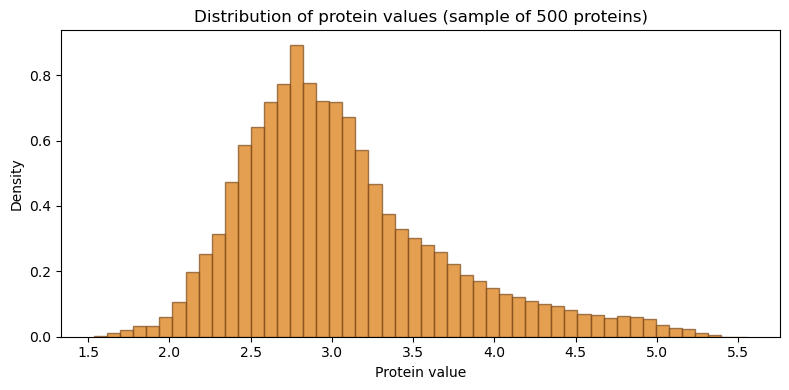

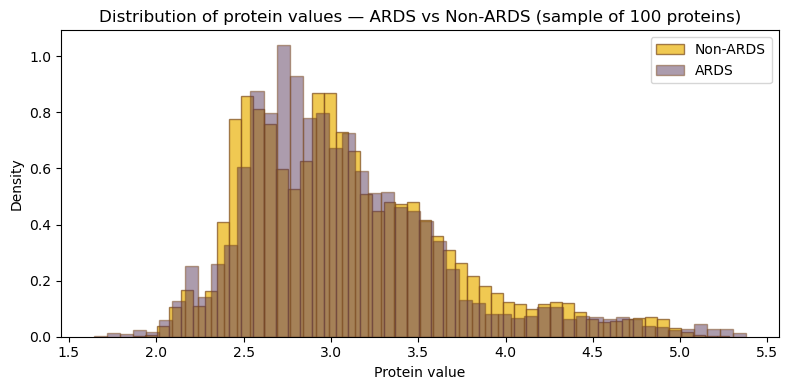

In [12]:
# ── Overall distribution (sample of 500 proteins) ─────────────────────────────
np.random.seed(42)
sample_vals = protein_data.sample(min(500, len(features)), axis=1).values.flatten()

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(sample_vals, bins=50, color=COLOR["primary"],
        edgecolor=COLOR["neutral"], alpha=0.7, density=True)
ax.set(title="Distribution of protein values (sample of 500 proteins)",
       xlabel="Protein value", ylabel="Density")
plt.tight_layout()
plt.show()

# ── ARDS vs Non-ARDS overlay (sample of 100 proteins each) ───────────────────
vals_ards     = protein_ards.sample(min(100, len(features)), axis=1).values.flatten()
vals_non_ards = protein_non_ards.sample(min(100, len(features)), axis=1).values.flatten()

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(vals_non_ards, bins=50, color=ARDS_COLORS["Not ARDS"],
        edgecolor=COLOR["neutral"], alpha=0.7, density=True, label="Non-ARDS")
ax.hist(vals_ards, bins=50, color=ARDS_COLORS["ARDS"],
        edgecolor=COLOR["neutral"], alpha=0.5, density=True, label="ARDS")
ax.set(title="Distribution of protein values — ARDS vs Non-ARDS (sample of 100 proteins)",
       xlabel="Protein value", ylabel="Density")
ax.legend()
plt.tight_layout()
plt.show()

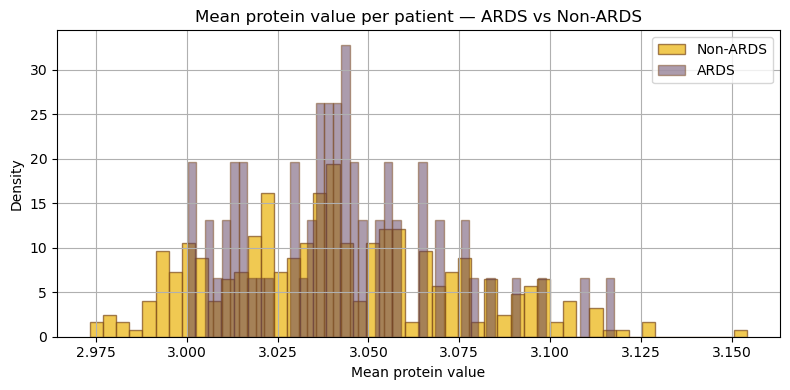

In [13]:
# ── Mean protein value per patient ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
protein_non_ards.mean(axis=1).hist(
    ax=ax, bins=50, color=ARDS_COLORS["Not ARDS"],
    edgecolor=COLOR["neutral"], density=True, alpha=0.7, label="Non-ARDS")
protein_ards.mean(axis=1).hist(
    ax=ax, bins=50, color=ARDS_COLORS["ARDS"],
    edgecolor=COLOR["neutral"], density=True, alpha=0.5, label="ARDS")
ax.set(title="Mean protein value per patient — ARDS vs Non-ARDS",
       xlabel="Mean protein value", ylabel="Density")
ax.legend()
plt.tight_layout()
plt.show()

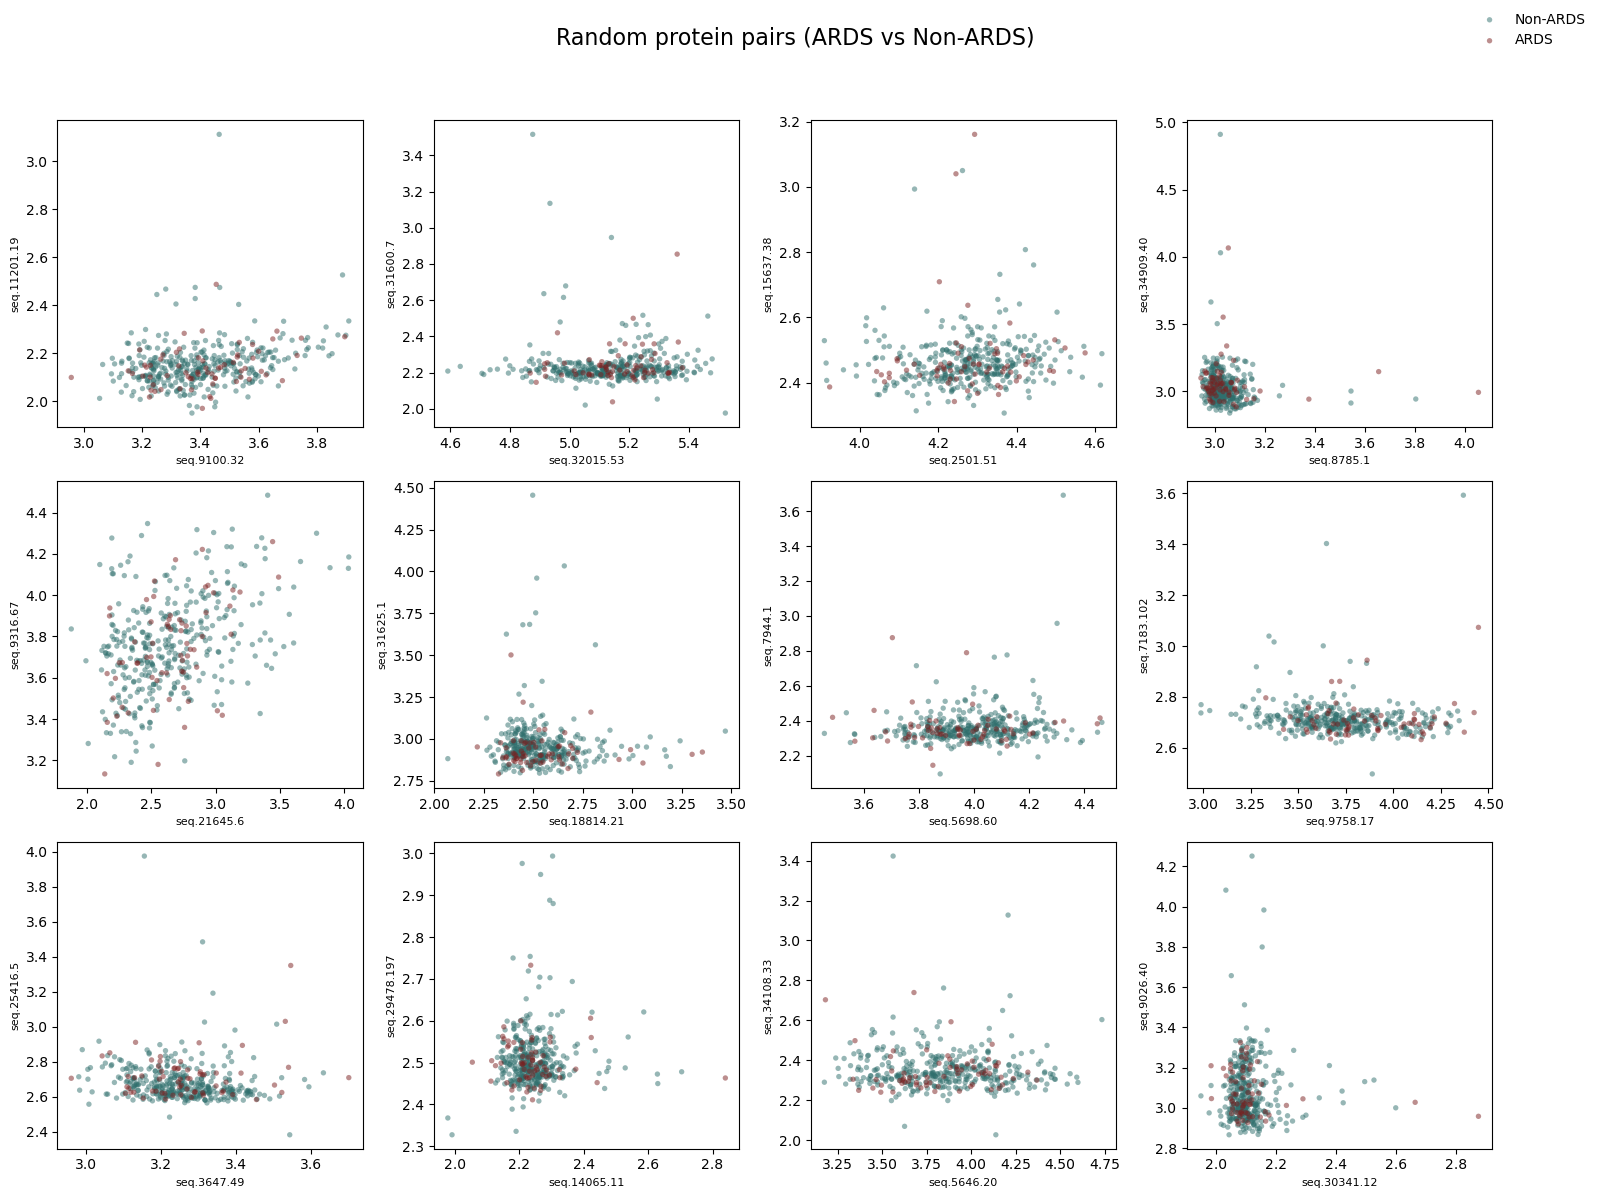

In [14]:
# ── 12 random protein-pair scatter plots ─────────────────────────────────────
np.random.seed(42)
pairs_scatter = [np.random.choice(features, 2, replace=False) for _ in range(12)]

mask_ards     = df["ards"] == True
mask_non_ards = df["ards"] == False

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for ax, (p1, p2) in zip(axes.flat, pairs_scatter):
    ax.scatter(
        protein_data.loc[mask_non_ards, p1],
        protein_data.loc[mask_non_ards, p2],
        s=15, alpha=0.5, color=COLOR["secondary"], edgecolors="none", label="Non-ARDS"
    )
    ax.scatter(
        protein_data.loc[mask_ards, p1],
        protein_data.loc[mask_ards, p2],
        s=15, alpha=0.5, color=COLOR["danger"], edgecolors="none", label="ARDS"
    )
    ax.set_xlabel(p1, fontsize=8)
    ax.set_ylabel(p2, fontsize=8)

handles, labels_legend = axes.flat[0].get_legend_handles_labels()
fig.legend(handles, labels_legend, loc="upper right", frameon=False)
fig.suptitle("Random protein pairs (ARDS vs Non-ARDS)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()

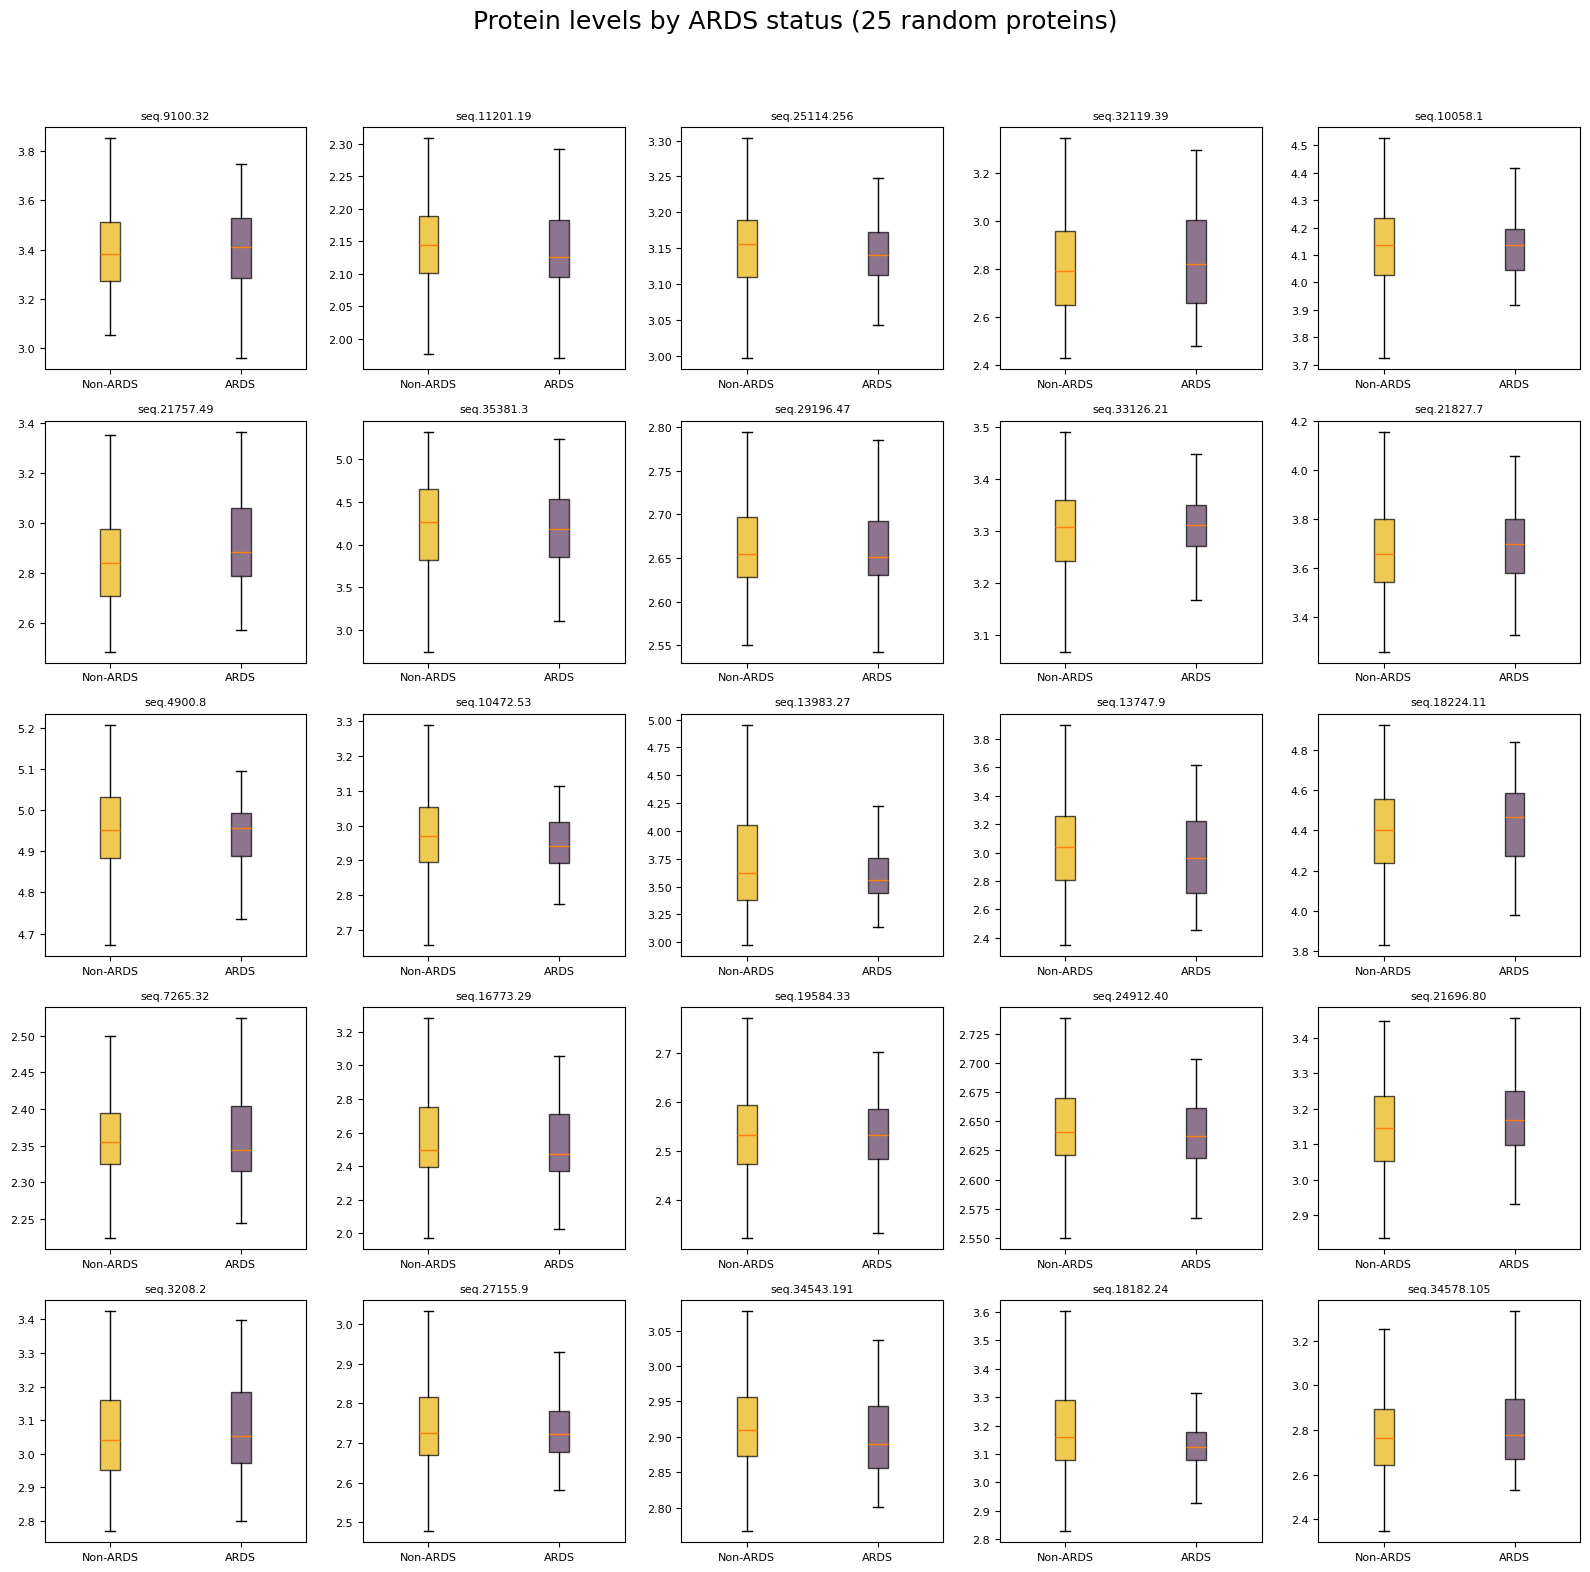

In [15]:
# ── 25 random protein boxplots ────────────────────────────────────────────────
np.random.seed(42)
rand_proteins = np.random.choice(features, 25, replace=False)

fig, axes = plt.subplots(5, 5, figsize=(16, 16))
for ax, p in zip(axes.flatten(), rand_proteins):
    vals_non = protein_non_ards[p].dropna()
    vals_a   = protein_ards[p].dropna()
    bp = ax.boxplot(
        [vals_non, vals_a],
        tick_labels=["Non-ARDS", "ARDS"],
        showfliers=False,
        patch_artist=True,
    )
    bp["boxes"][0].set_facecolor(ARDS_COLORS["Not ARDS"])
    bp["boxes"][1].set_facecolor(ARDS_COLORS["ARDS"])
    for box in bp["boxes"]:
        box.set_alpha(0.7)
    ax.set_title(p, fontsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

fig.suptitle("Protein levels by ARDS status (25 random proteins)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 5. Protein data — differential analysis (ARDS vs Non-ARDS)

### 5.1 Random protein distributions

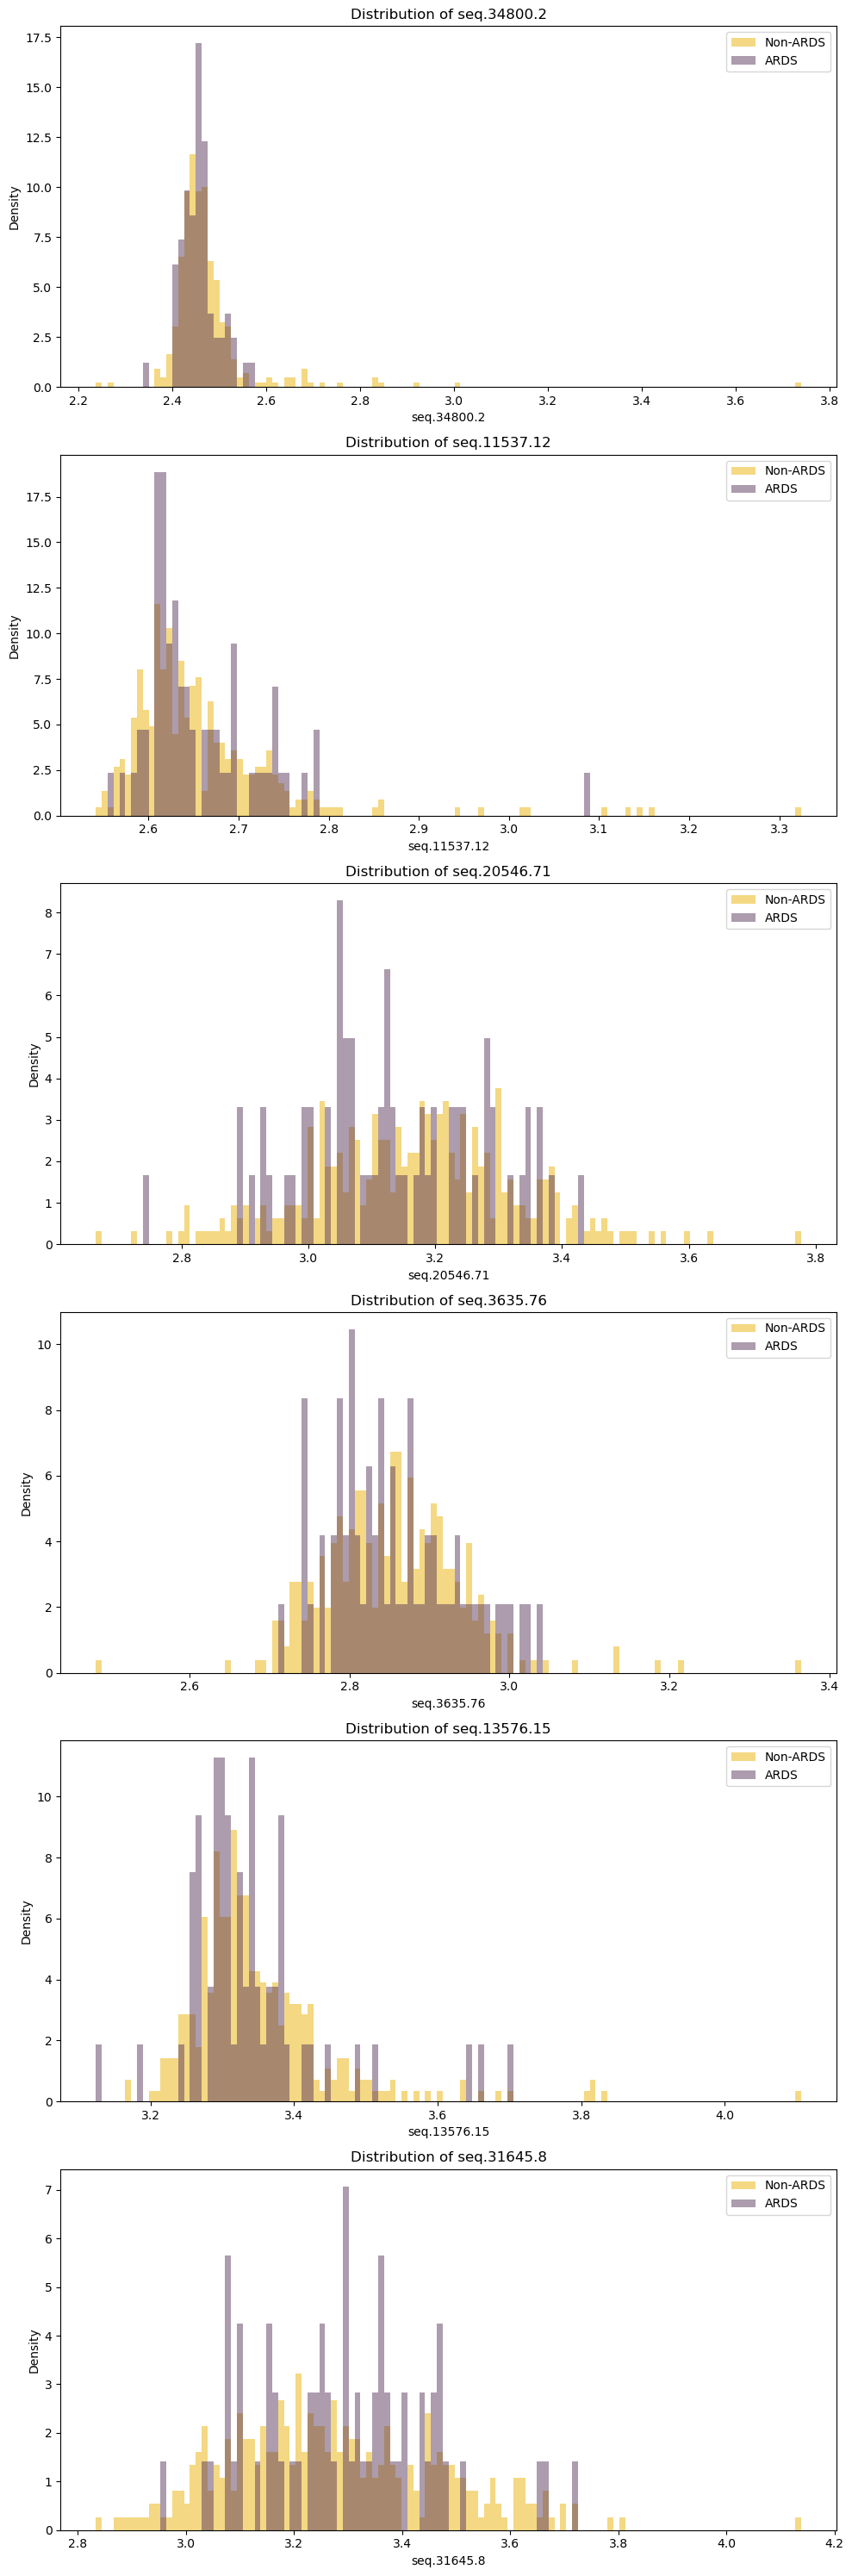

In [16]:
np.random.seed(0)
random_feats = np.random.choice(features, size=min(6, len(features)), replace=False)

fig, axes = plt.subplots(len(random_feats), 1, figsize=(10, 5 * len(random_feats)))
if len(random_feats) == 1:
    axes = np.array([axes])

for ax, feat in zip(axes, random_feats):
    hist_range = (
        min(non_ards_data[feat].min(), ards_data[feat].min()),
        max(non_ards_data[feat].max(), ards_data[feat].max()),
    )
    ax.hist(non_ards_data[feat].dropna(), bins=120, alpha=0.5,
            color=ARDS_COLORS["Not ARDS"], label="Non-ARDS",
            density=True, range=hist_range)
    ax.hist(ards_data[feat].dropna(), bins=120, alpha=0.5,
            color=ARDS_COLORS["ARDS"], label="ARDS",
            density=True, range=hist_range)
    ax.set(title=f"Distribution of {feat}",
           xlabel=feat, ylabel="Density")
    ax.legend()

plt.tight_layout()
plt.show()

### 5.2 Top proteins by mean absolute difference

In [17]:
k = 6
top_features = get_top_diff_features(non_ards_data, ards_data, k=k)
print(f"Top {k} proteins by |mean(Non-ARDS) − mean(ARDS)|:")
for rank, feat in enumerate(top_features, 1):
    diff_val = abs(non_ards_data[feat].mean() - ards_data[feat].mean())
    print(f"  {rank}. {feat}  (Δ = {diff_val:.4f})")

Top 6 proteins by |mean(Non-ARDS) − mean(ARDS)|:
  1. seq.18173.11  (Δ = 0.2582)
  2. seq.8325.37  (Δ = 0.2445)
  3. seq.31045.18  (Δ = 0.2319)
  4. seq.15525.294  (Δ = 0.2311)
  5. seq.4125.52  (Δ = 0.2235)
  6. seq.19506.6  (Δ = 0.2222)


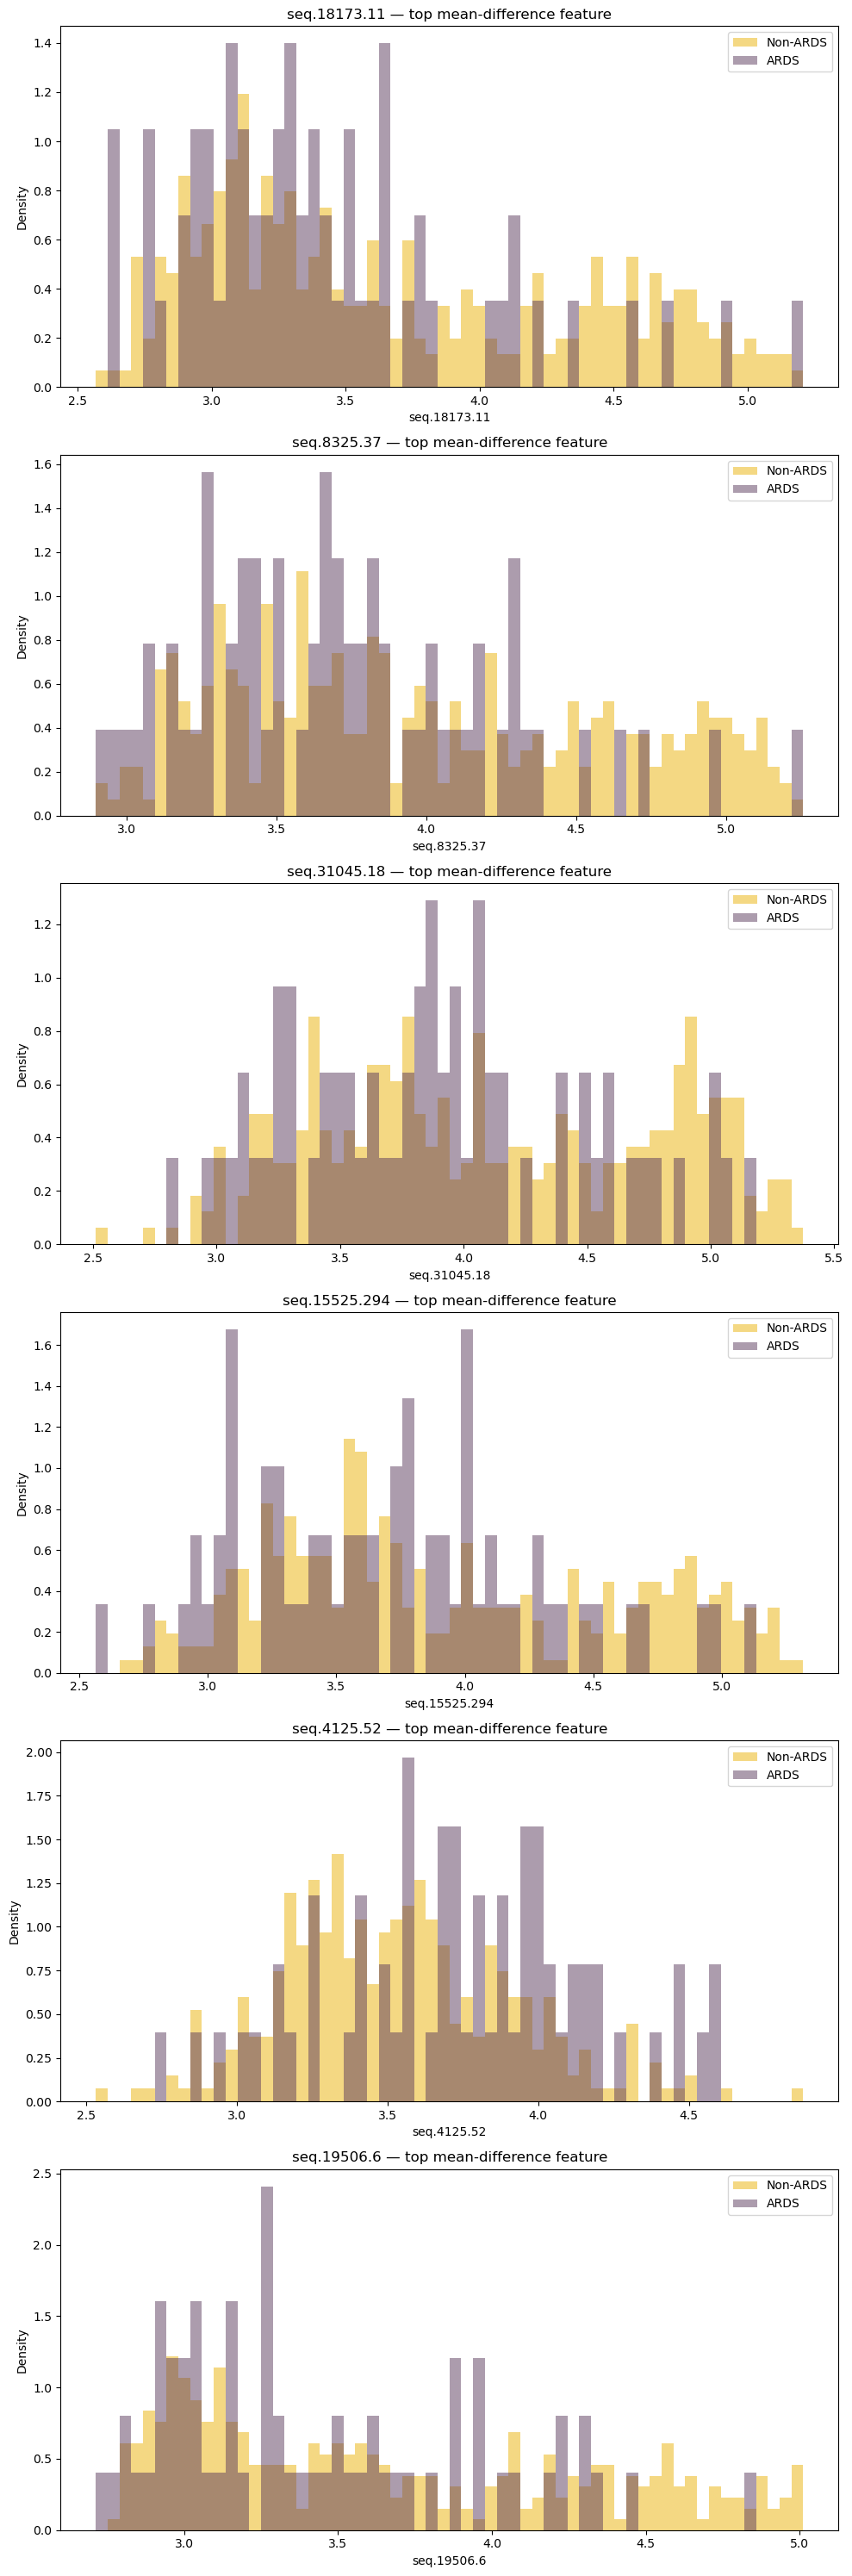

In [18]:
fig, axes = plt.subplots(len(top_features), 1, figsize=(10, 5 * len(top_features)))
if len(top_features) == 1:
    axes = np.array([axes])

for ax, feat in zip(axes, top_features):
    hist_min = min(non_ards_data[feat].dropna().min(), ards_data[feat].dropna().min())
    hist_max = max(non_ards_data[feat].dropna().max(), ards_data[feat].dropna().max())
    hist_range = (hist_min, hist_max)

    ax.hist(non_ards_data[feat].dropna(), bins=60, alpha=0.5,
            color=ARDS_COLORS["Not ARDS"], label="Non-ARDS",
            density=True, range=hist_range)
    ax.hist(ards_data[feat].dropna(), bins=60, alpha=0.5,
            color=ARDS_COLORS["ARDS"], label="ARDS",
            density=True, range=hist_range)
    ax.set(title=f"{feat} — top mean-difference feature",
           xlabel=feat, ylabel="Density")
    ax.legend()

plt.tight_layout()
plt.show()

### 5.3 Top proteins — sex breakdown

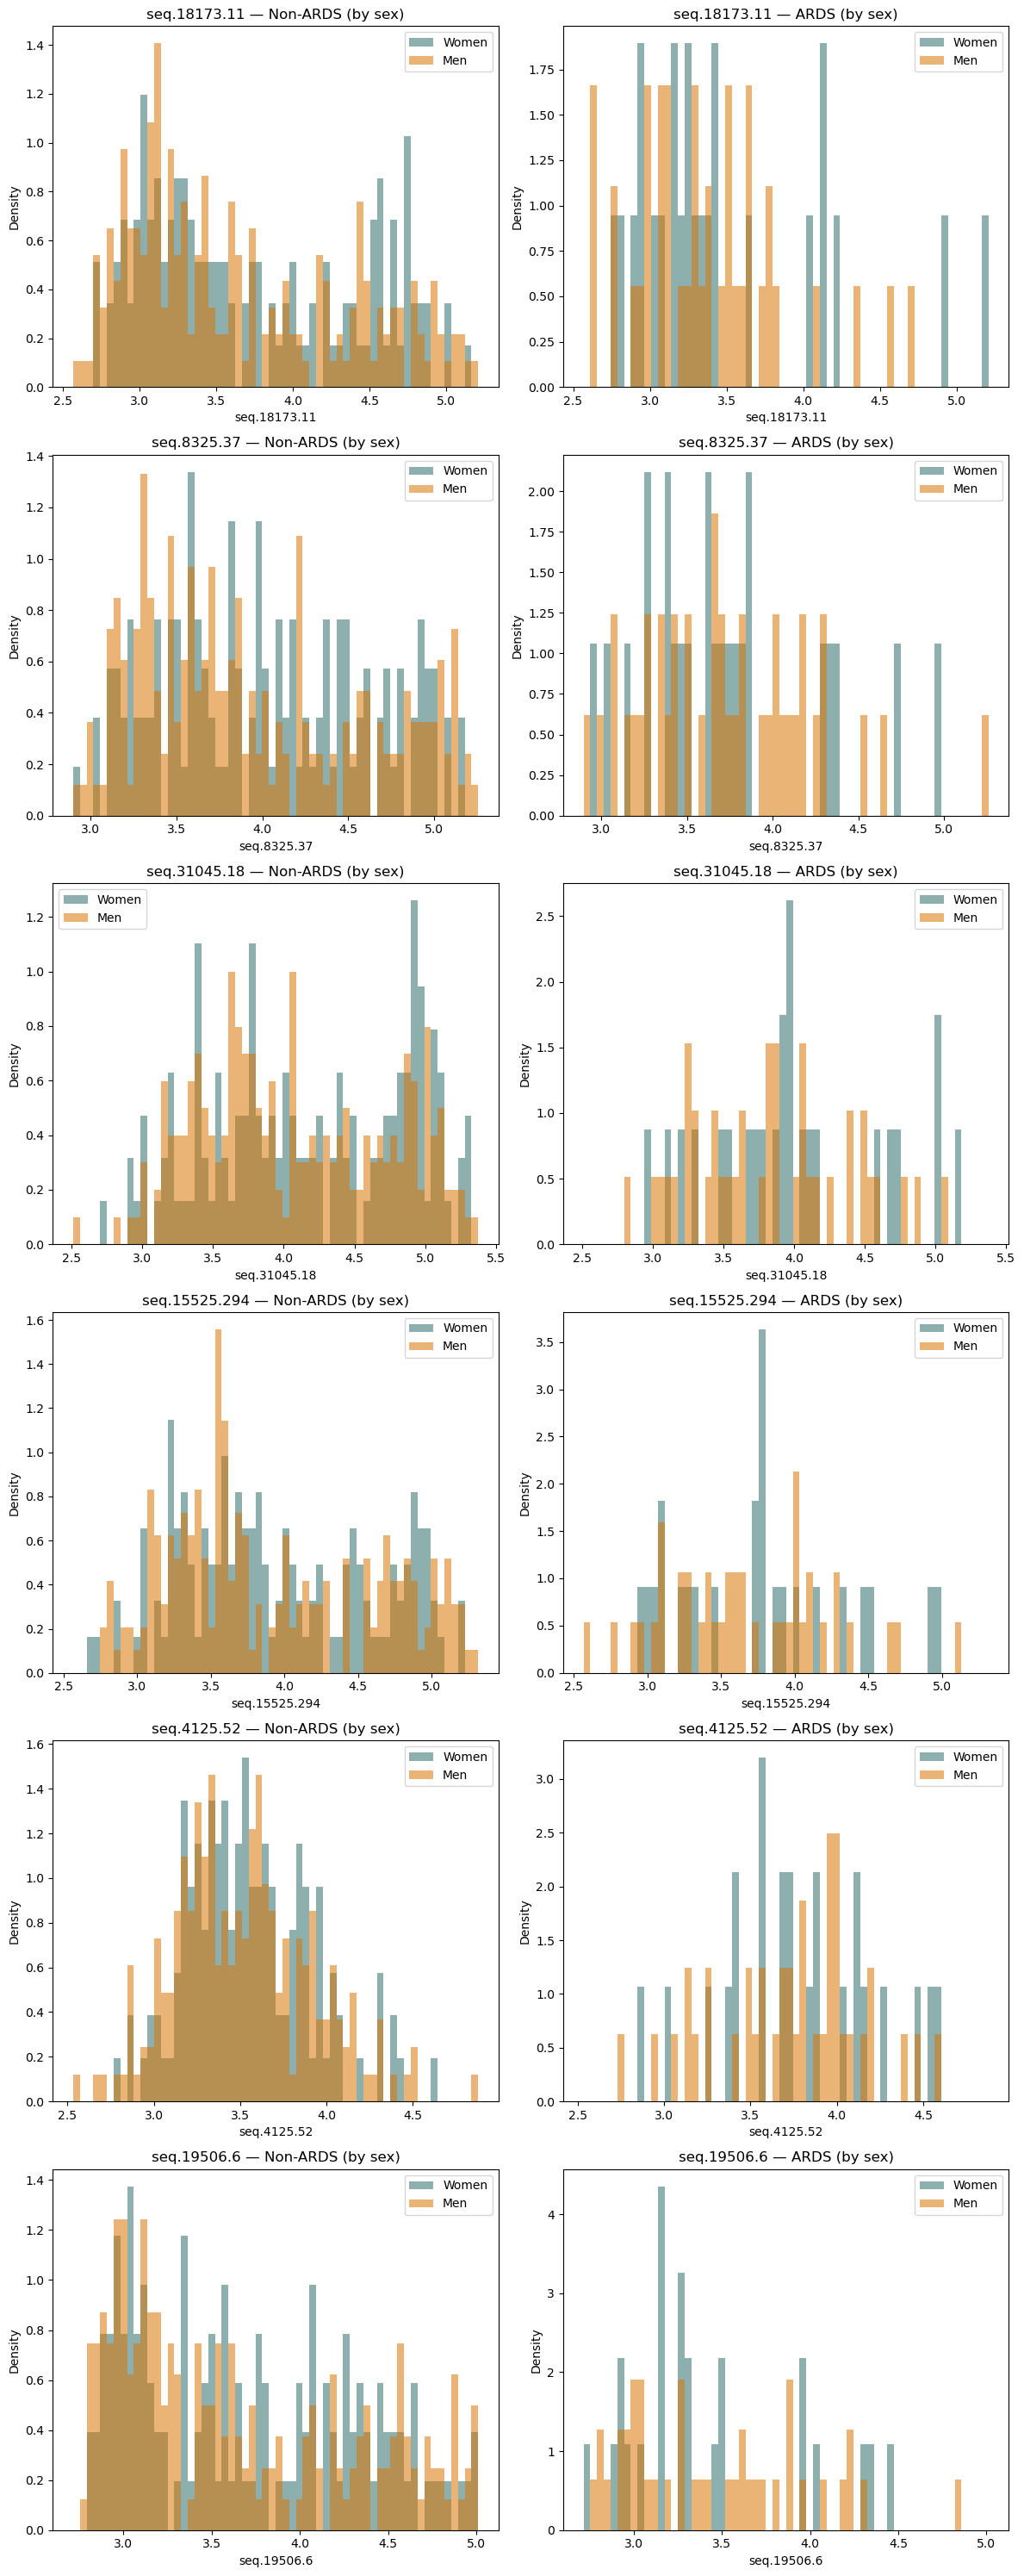

In [19]:
fig, axes = plt.subplots(len(top_features), 2,
                         figsize=(12, 5 * len(top_features)))
if len(top_features) == 1:
    axes = np.array([axes])

for i, feat in enumerate(top_features):
    female_non_ards = non_ards_data[non_ards_data["female"] == 1]
    male_non_ards   = non_ards_data[non_ards_data["female"] == 0]
    female_ards     = ards_data[ards_data["female"] == 1]
    male_ards       = ards_data[ards_data["female"] == 0]

    hist_min = min(non_ards_data[feat].dropna().min(), ards_data[feat].dropna().min())
    hist_max = max(non_ards_data[feat].dropna().max(), ards_data[feat].dropna().max())
    hist_range = (hist_min, hist_max)

    # Left: Non-ARDS
    axes[i, 0].hist(female_non_ards[feat].dropna(), bins=60, alpha=0.55,
                    color=COLORS[1], label="Women", density=True, range=hist_range)
    axes[i, 0].hist(male_non_ards[feat].dropna(),   bins=60, alpha=0.55,
                    color=COLORS[0], label="Men",   density=True, range=hist_range)
    axes[i, 0].set(title=f"{feat} — Non-ARDS (by sex)",
                   xlabel=feat, ylabel="Density")
    axes[i, 0].legend()

    # Right: ARDS
    axes[i, 1].hist(female_ards[feat].dropna(), bins=60, alpha=0.55,
                    color=COLORS[1], label="Women", density=True, range=hist_range)
    axes[i, 1].hist(male_ards[feat].dropna(),   bins=60, alpha=0.55,
                    color=COLORS[0], label="Men",   density=True, range=hist_range)
    axes[i, 1].set(title=f"{feat} — ARDS (by sex)",
                   xlabel=feat, ylabel="Density")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

### 5.4 Cross-feature scatter plots (top proteins)

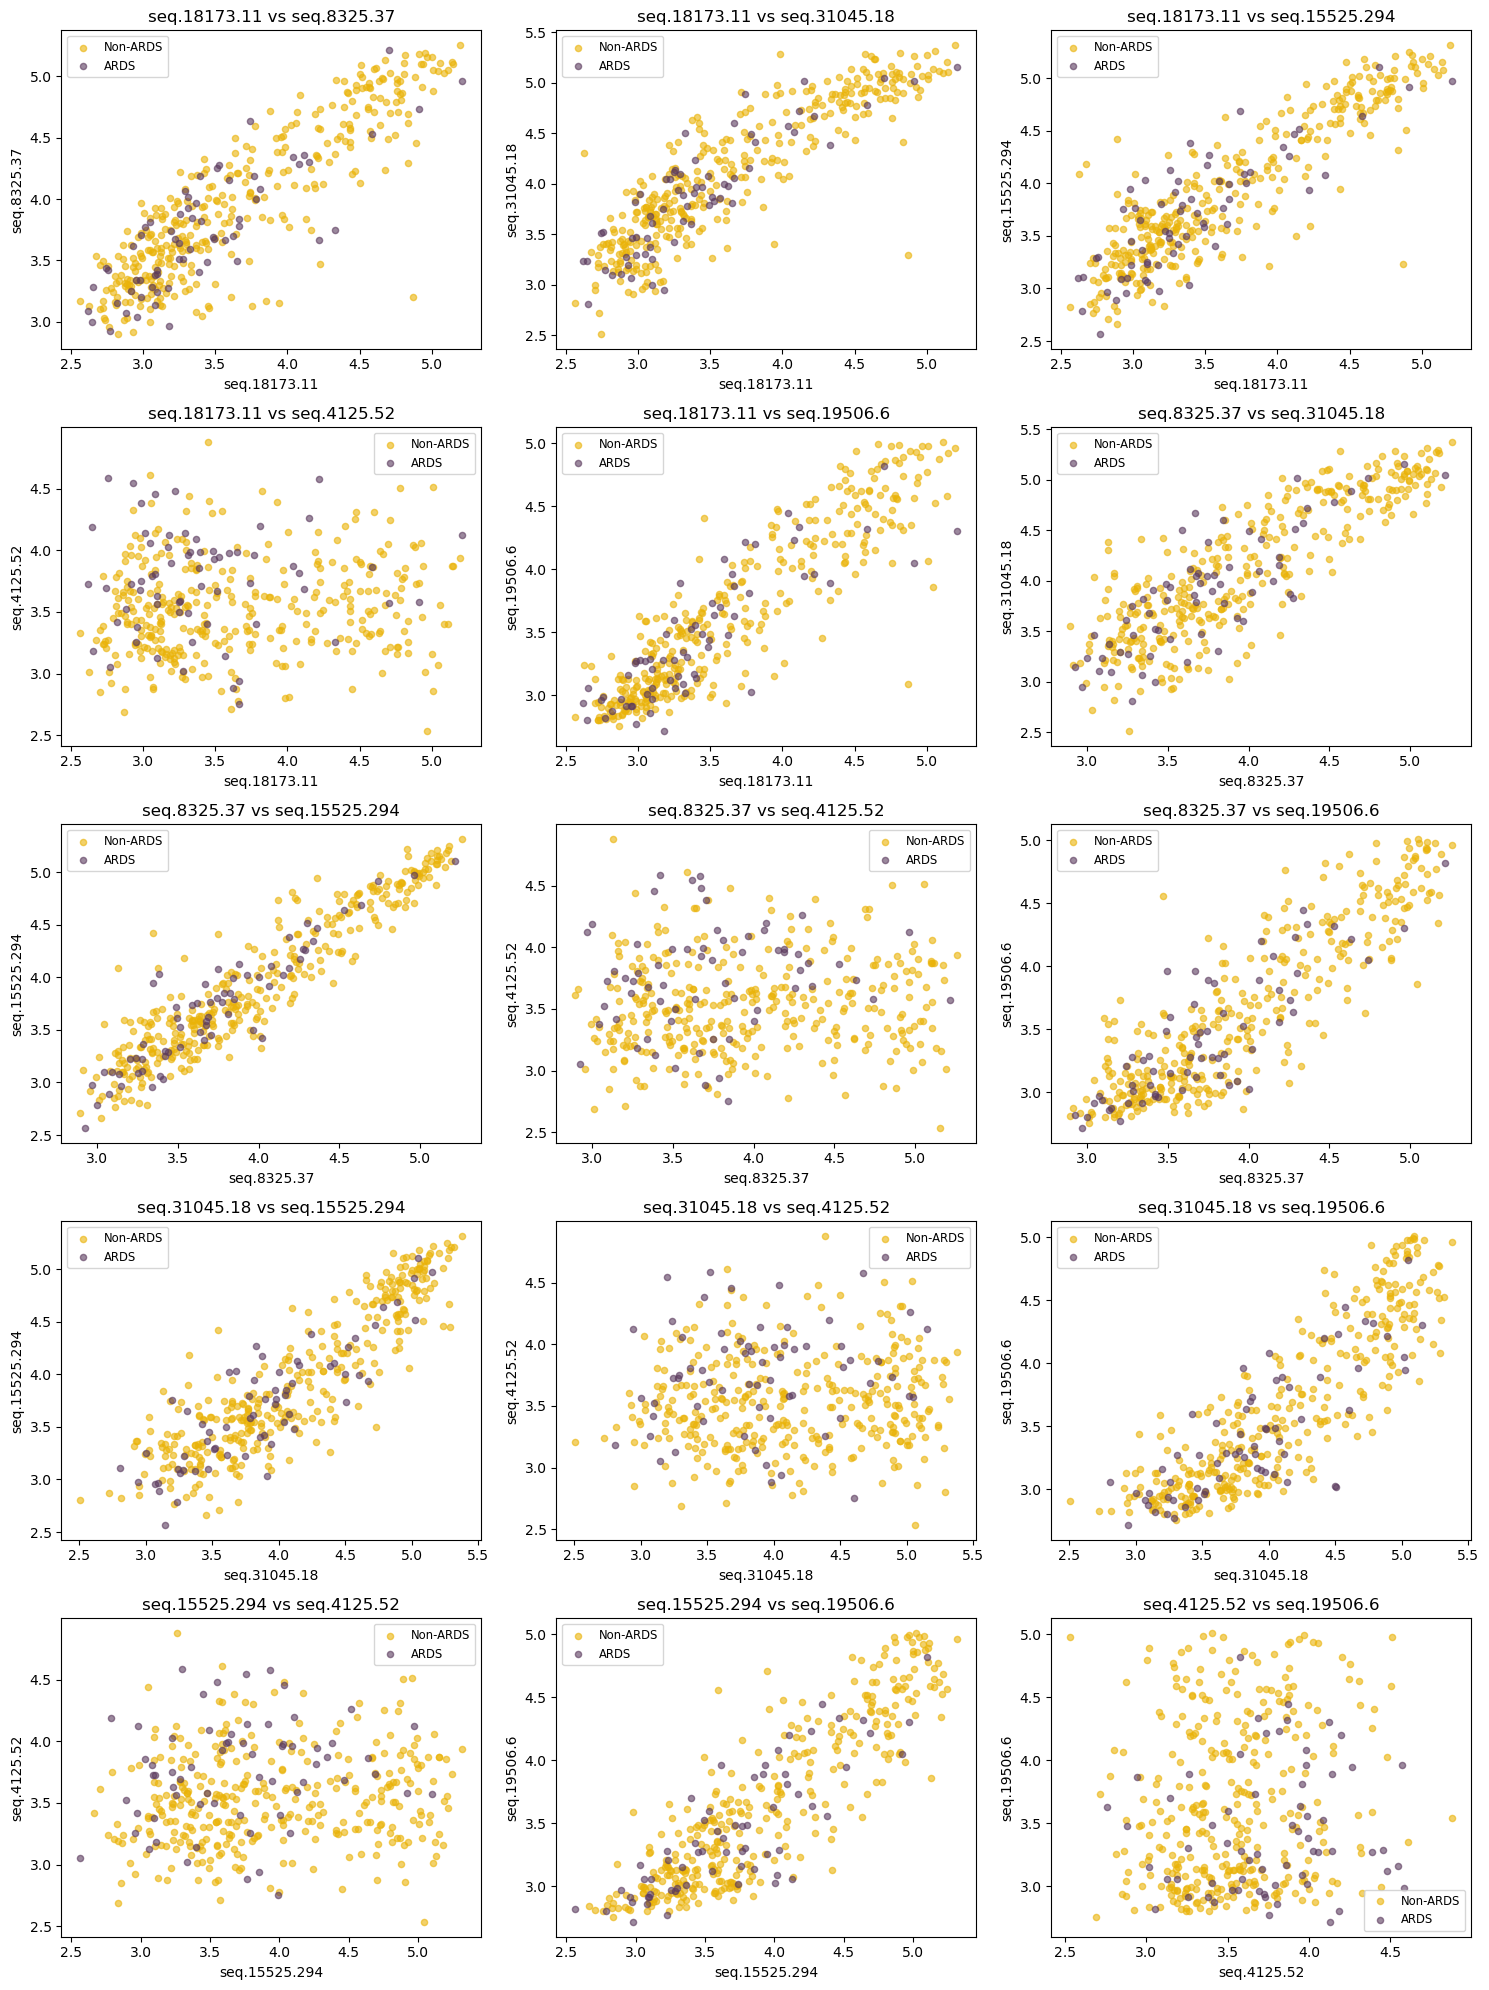

In [20]:
pairs = list(itertools.combinations(top_features, 2))[:15]
ncols = 3
nrows = (len(pairs) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(5 * ncols, 4 * nrows), squeeze=False)

for idx, (f1, f2) in enumerate(pairs):
    r, c = divmod(idx, ncols)
    ax = axes[r][c]
    ax.scatter(
        protein_non_ards[f1], protein_non_ards[f2],
        s=20, alpha=0.6, color=ARDS_COLORS["Not ARDS"], label="Non-ARDS"
    )
    ax.scatter(
        protein_ards[f1], protein_ards[f2],
        s=20, alpha=0.6, color=ARDS_COLORS["ARDS"], label="ARDS"
    )
    ax.set(xlabel=f1, ylabel=f2, title=f"{f1} vs {f2}")
    ax.legend(fontsize="small")

# Hide unused axes
for i in range(len(pairs), nrows * ncols):
    axes[i // ncols][i % ncols].axis("off")

plt.tight_layout()
plt.show()

### 5.5 Protein–protein correlation heatmaps (hierarchically clustered)

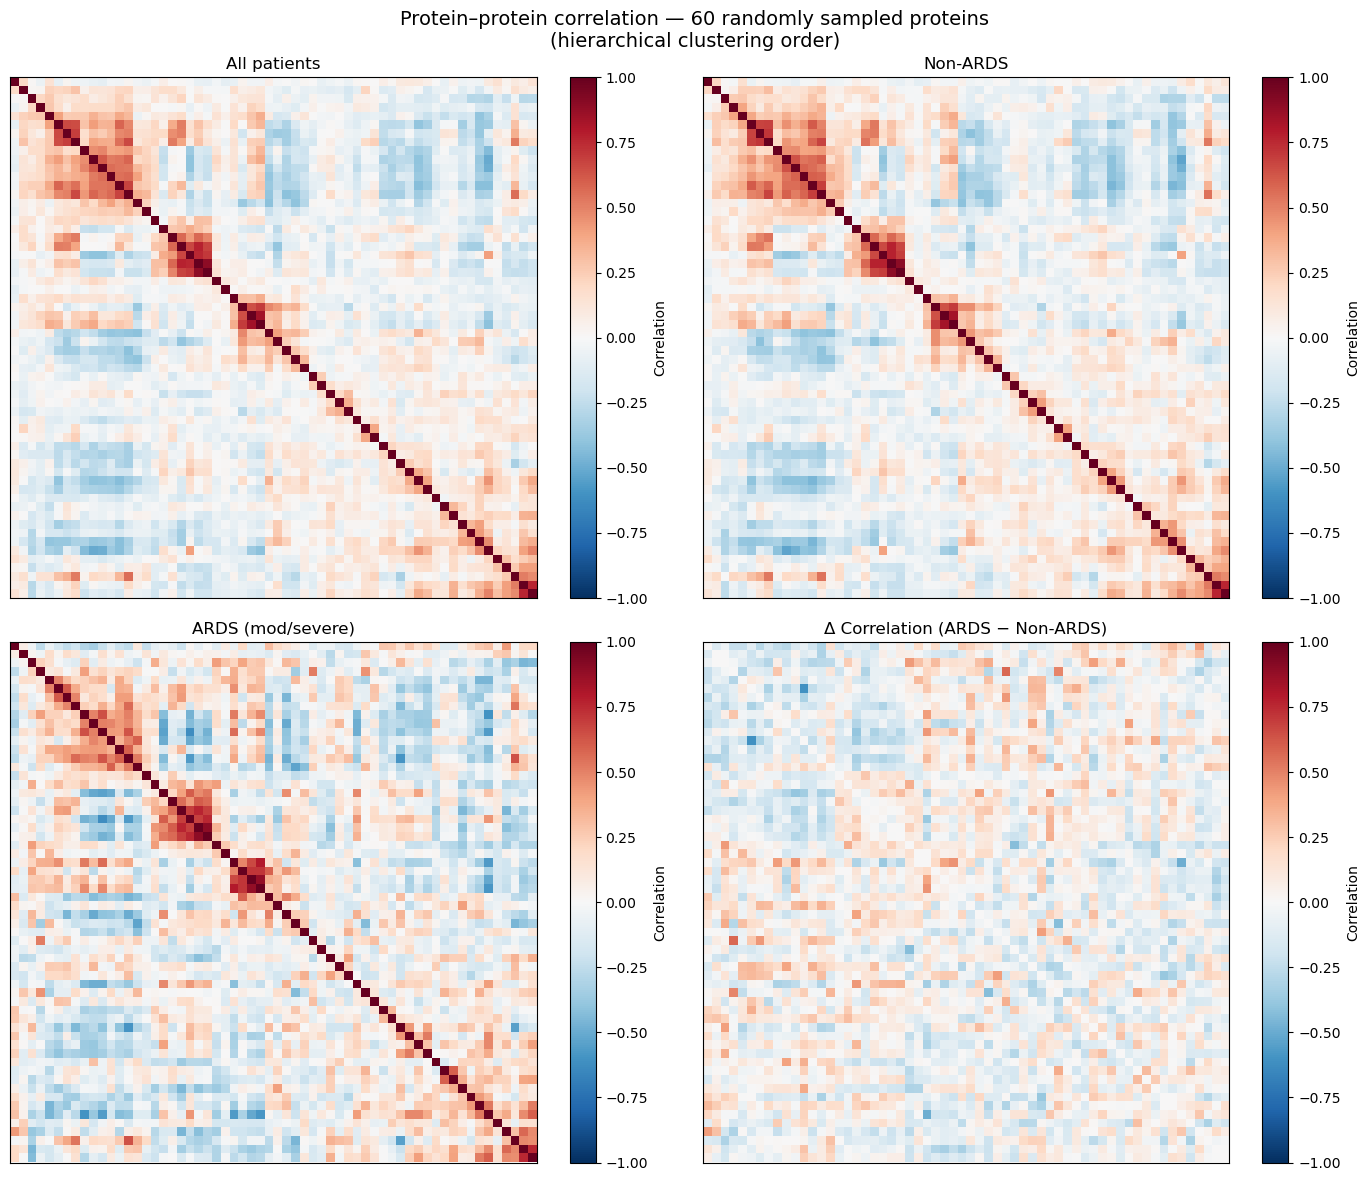

In [21]:
np.random.seed(1)
n_corr = min(60, len(features))
corr_feats = np.random.choice(features, size=n_corr, replace=False)

corr_all     = corr_matrix(df,           list(corr_feats))
corr_ards    = corr_matrix(ards_data,    list(corr_feats))
corr_non     = corr_matrix(non_ards_data, list(corr_feats))
corr_diff    = corr_ards - corr_non

# Compute hierarchical order from the full-cohort correlation
ordered_feats = hierarchical_feature_order(corr_all)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plot_correlation_heatmap(corr_all,  "All patients",          ordered_feats, ax=axes[0, 0])
plot_correlation_heatmap(corr_non,  "Non-ARDS",              ordered_feats, ax=axes[0, 1])
plot_correlation_heatmap(corr_ards, "ARDS (mod/severe)",     ordered_feats, ax=axes[1, 0])
plot_correlation_heatmap(
    corr_diff,
    "Δ Correlation (ARDS − Non-ARDS)",
    ordered_feats,
    ax=axes[1, 1],
    vmin=-1.0, vmax=1.0,
)
fig.suptitle(
    f"Protein–protein correlation — {n_corr} randomly sampled proteins\n"
    "(hierarchical clustering order)",
    fontsize=14,
)
plt.tight_layout()
plt.show()